In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import graphviz
import pydot
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

2023-11-29 16:53:02.409311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 16:53:02.526801: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-29 16:53:02.526827: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-29 16:53:02.551831: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 16:53:03.701878: W tensorflow/stream_executor/platform/de

In [2]:
# Parameters:
LOOKBACK = 20

In [3]:
# Load and preprocess the data
data = yf.download("^SPX", start="1988-01-01", end="2023-10-30")
data.index = data.index.date

data['Daily_Returns'] = data['Adj Close'].pct_change()
data = data.dropna()

# initialize a column for predicted returns
data['Predicted_Returns'] = np.nan 

[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_182/3543858182.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Predicted_Returns'] = np.nan


In [4]:
start_date = datetime.date(1988, 1, 1)
end_date = datetime.date(2023, 10, 30)

performance_metrics = []

while start_date < end_date:
    train_start = start_date
    train_end = start_date + datetime.timedelta(days=365*2)
    validation_start = train_end
    validation_end = validation_start + datetime.timedelta(days=365)
    test_start = validation_end
    test_end = test_start + datetime.timedelta(days=365)

    if test_end > end_date:
        break
    #if test_end > end_date + datetime.timedelta(days=365*4):
    #    break

    train_data = data.loc[train_start:validation_end]
    test_data = data.loc[test_start:test_end]

    close_prices = train_data['Close'].values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data['Daily_Returns'].values.reshape(-1, 1))

    X_train, y_train = [], []
    look_back = LOOKBACK

    for i in range(look_back, len(train_scaled)):
        X_train.append(train_scaled[i-look_back:i, 0])
        y_train.append(train_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.33)

    test_scaled = scaler.transform(test_data['Daily_Returns'].values.reshape(-1, 1))

    X_test, y_test = [], []
    for i in range(LOOKBACK, len(test_scaled)):
        X_test.append(test_scaled[i-LOOKBACK:i, 0])
        y_test.append(test_scaled[i, 0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Making predictions on the test data
    predicted_returns = model.predict(X_test)
    predicted_returns = scaler.inverse_transform(predicted_returns)

    # Performance evaluation on returns
    real_returns = test_data['Daily_Returns'].values[LOOKBACK:]
    mse_returns = mean_squared_error(real_returns, predicted_returns)
    rmse_returns = np.sqrt(mse_returns)

    print(" ######## MODEL (", train_start, "/", validation_end, ") ######## ")
    print("Mean Squared Error on Returns:", mse_returns)
    print("Root Mean Squared Error on Returns:", rmse_returns)

    entry = {validation_end: (mse_returns, rmse_returns)}
    performance_metrics.append(entry)

    test_dates = test_data.index[LOOKBACK:]
    predictions_series = pd.Series(data=predicted_returns.flatten(), index=test_dates)
    data.loc[test_dates, 'Predicted_Returns'] = predictions_series

    start_date = start_date + datetime.timedelta(days=365)

2023-11-29 16:53:06.706073: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-11-29 16:53:06.706105: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-29 16:53:06.706126: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-0b986107-e036-494e-b644-ef8c9f84d281): /proc/driver/nvidia/version does not exist
2023-11-29 16:53:06.706338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Epoch 1/10
16/16 [==============================] - 4s 77ms/step - loss: 0.1549 - va

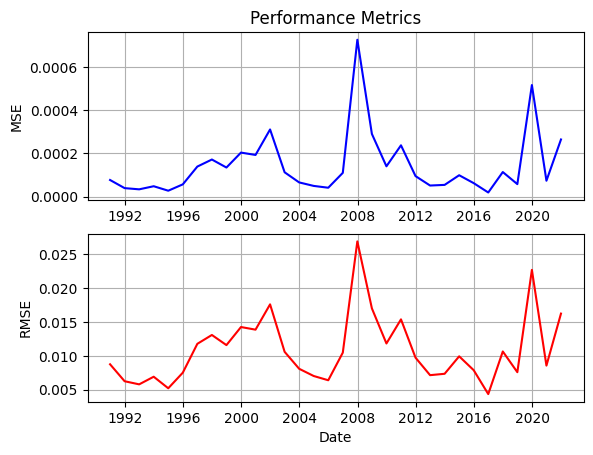

In [5]:
dates = []
mse = []
rmse = []

for data_dict in performance_metrics:
    for date, values in data_dict.items():
        dates.append(date)
        mse.append(values[0])
        rmse.append(values[1])

plt.subplot(2, 1, 1)
plt.plot(dates, mse, label='MSE', color='blue')
plt.ylabel('MSE')
plt.title('Performance Metrics')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(dates, rmse, label='RMSE', color='red')
plt.xlabel('Date')
plt.ylabel('RMSE')
plt.grid(True)


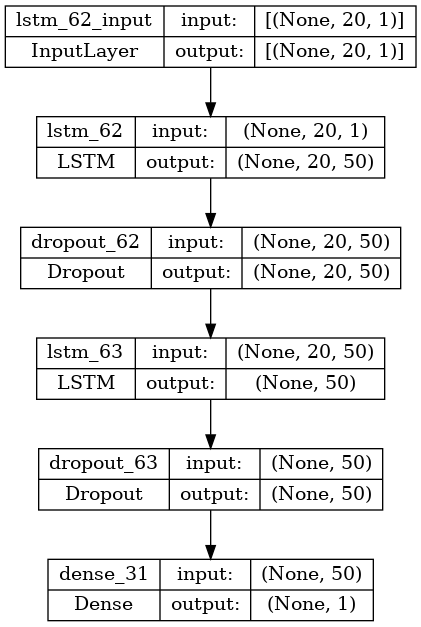

In [6]:
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

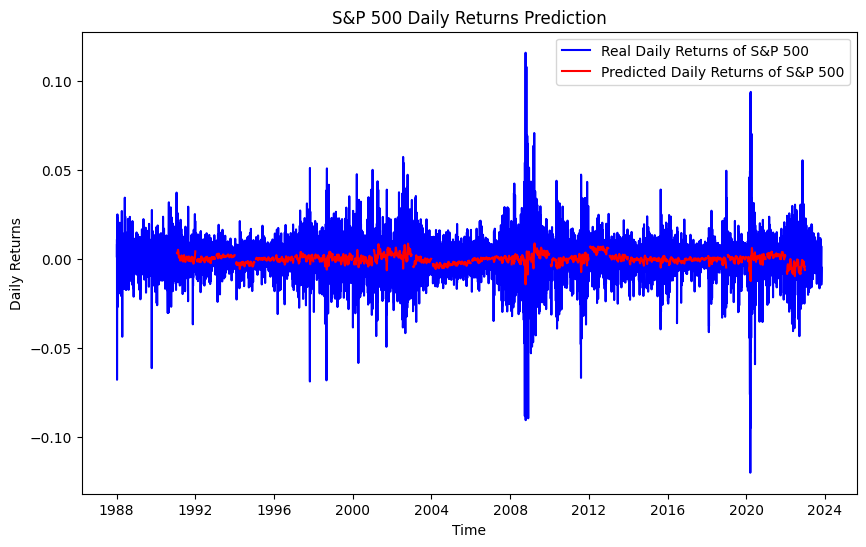

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(data['Daily_Returns'], color='blue', label='Real Daily Returns of S&P 500')
plt.plot(data['Predicted_Returns'], color='red', label='Predicted Daily Returns of S&P 500')
plt.title('S&P 500 Daily Returns Prediction')
plt.xlabel('Time')
plt.ylabel('Daily Returns')
plt.legend()
plt.show()

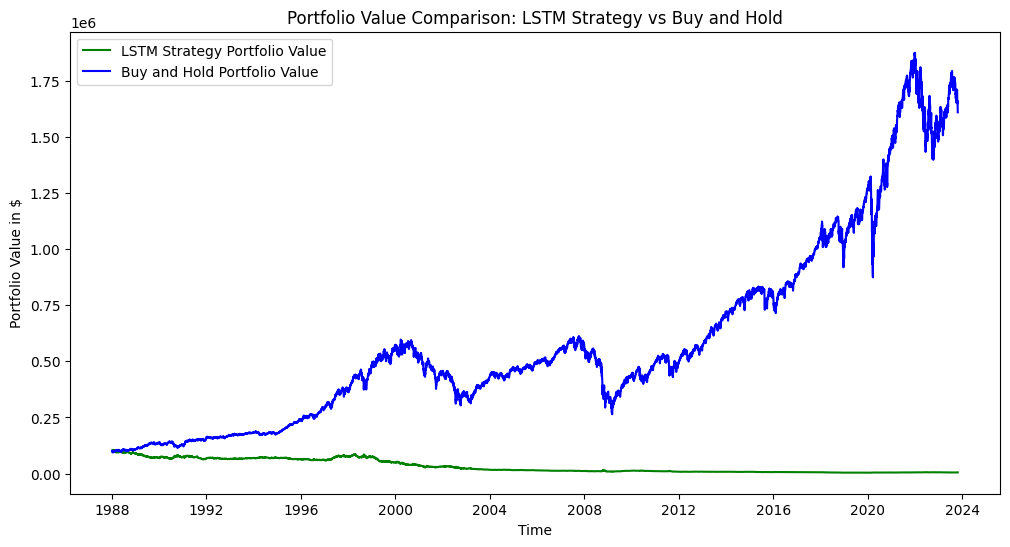

In [8]:
FEE_PER_TRADE = 0.0005
STARTING_CAPITAL = 100000

signals = np.where(data['Predicted_Returns'] > 0, 1, -1)

portfolio_value = [STARTING_CAPITAL]
previous_signal = signals[0]

dates = data.index

for i in range(1, len(signals)):
    trade_made = signals[i] != previous_signal
    fee = FEE_PER_TRADE if trade_made else 0
    trade_return = signals[i] * data['Daily_Returns'].iloc[i] - fee
    new_value = portfolio_value[-1] * (1 + trade_return)
    portfolio_value.append(new_value)
    previous_signal = signals[i]

portfolio_values_series = pd.Series(portfolio_value, index=dates)

cumulative_returns = (1 + data['Daily_Returns']).cumprod()
buy_and_hold = STARTING_CAPITAL * cumulative_returns

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values_series, label='LSTM Strategy Portfolio Value', color='green')
plt.plot(buy_and_hold, label='Buy and Hold Portfolio Value', color='blue')
plt.title('Portfolio Value Comparison: LSTM Strategy vs Buy and Hold')
plt.xlabel('Time')
plt.ylabel('Portfolio Value in $')
plt.legend()
plt.show()


In [9]:
TRADING_DAYS = 252 
RISK_FREE_RATE = 0.0452

lstm_returns = portfolio_values_series.pct_change().dropna()
buy_and_hold_returns = buy_and_hold.pct_change().dropna()

annualized_return_lstm = np.prod(1 + lstm_returns) ** (TRADING_DAYS / len(lstm_returns)) - 1
annualized_return_bh = np.prod(1 + buy_and_hold_returns) ** (TRADING_DAYS / len(buy_and_hold_returns)) - 1

annualized_std_lstm = np.std(lstm_returns) * np.sqrt(TRADING_DAYS)
annualized_std_bh = np.std(buy_and_hold_returns) * np.sqrt(TRADING_DAYS)

sharpe_ratio_lstm = (annualized_return_lstm - RISK_FREE_RATE) / annualized_std_lstm
sharpe_ratio_bh = (annualized_return_bh - RISK_FREE_RATE) / annualized_std_bh

active_return = lstm_returns - buy_and_hold_returns
tracking_error = np.std(active_return)
information_ratio = np.mean(active_return) / tracking_error

metrics = pd.DataFrame({
    'Metric': ['Annualized Return', 'Annualized Std Dev', 'Sharpe Ratio', 'Information Ratio'],
    'LSTM Strategy': [annualized_return_lstm, annualized_std_lstm, sharpe_ratio_lstm, information_ratio],
    'Buy and Hold': [annualized_return_bh, annualized_std_bh, sharpe_ratio_bh, np.nan]  # No IR for Buy and Hold
})

print(metrics)


               Metric  LSTM Strategy  Buy and Hold
0   Annualized Return      -0.077187      0.080342
1  Annualized Std Dev       0.180380      0.180306
2        Sharpe Ratio      -0.678495      0.194900
3   Information Ratio      -0.033729           NaN


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0b986107-e036-494e-b644-ef8c9f84d281' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>